### 비트코인 가격 예측

21600057 김동준, 21800663 정수현  


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense, Activation
from keras.callbacks import TensorBoard, ModelCheckpoint, ReduceLROnPlateau
import datetime

데이터 출처 링크 : https://finance.yahoo.com/quote/BTC-USD/history?p=BTC-USD

In [2]:
# Load Data 

data = pd.read_csv('BTC-USD.csv') # 비트코인 가격에 대한 csv 파일을 읽음
data.head() # 데이터를 상위 5줄만 보여줌

,Date,Open,High,Low,Close,Adj Close,Volume
0,2020-05-28,9184.945313,9546.319336,9148.457031,9525.750977,9525.750977,3.436707e+10
1,2020-05-29,9528.355469,9573.666992,9379.338867,9439.124023,9439.124023,3.289664e+10
2,2020-05-30,9438.914063,9704.030273,9366.729492,9700.414063,9700.414063,3.272298e+10
3,2020-05-31,9700.105469,9700.343750,9432.296875,9461.058594,9461.058594,2.777329e+10
4,2020-06-01,9463.605469,10199.565430,9450.899414,10167.268560,10167.268560,3.519890e+10


In [4]:
high_prices = data['High'].values # hgih_prices에 대한 값을 ndarray로 저장 
low_prices = data['Low'].values # low_prices에 대한 값을 ndarray로 저장
mid_prices = (high_prices + low_prices) / 2 # 평균값에 대한 값을 ndarray로 저장
print(mid_prices)
print(len(mid_prices))

[ 9347.3881835  9476.5029295  9535.3798825  9566.3203125  9825.232422
  9821.4560545  9577.3530275  9706.428711   9766.227051   9682.2280275
  9613.324219   9729.0961915  9750.544434   9818.59375    9600.683594
  9413.1586915  9444.61084    9414.932129   9247.5180665  9489.9379885
  9433.881348   9405.5888675  9357.5859375  9321.1757815  9350.769043
  9475.972656   9608.894043   9479.300293   9217.742676   9206.1274415
  9103.013672   9086.536133   9139.7246095  9151.3369145  9207.2451175
  9155.792969   9130.5698245  9118.4628905  9069.5996095  9217.069336
  9281.216309   9349.917969   9333.1889645  9202.7368165  9246.5087895
  9258.43457    9265.349121   9227.751465   9223.6293945  9151.629883
  9135.728027   9165.9038085  9149.5156255  9175.890137   9278.3261715
  9425.0859375  9546.625488   9552.395508   9617.3842775  9838.327638
 10601.0957035 10918.479495  11080.26953   11032.405765  11201.458985
 11517.229005  11526.137205  11232.74707   11239.763675  11472.451175
 11750.524905 

In [10]:
seq_len = 50
sequence_length = seq_len + 1

result = []
for index in range(len(mid_prices) - sequence_length):
    result.append(mid_prices[index: index + sequence_length]) # result의 인덱스마다 51개의 평균값을 저장.
print(len(result))
print(len(result[0]))
print(result[0])


311
51
[9347.3881835 9476.5029295 9535.3798825 9566.3203125 9825.232422
 9821.4560545 9577.3530275 9706.428711  9766.227051  9682.2280275
 9613.324219  9729.0961915 9750.544434  9818.59375   9600.683594
 9413.1586915 9444.61084   9414.932129  9247.5180665 9489.9379885
 9433.881348  9405.5888675 9357.5859375 9321.1757815 9350.769043
 9475.972656  9608.894043  9479.300293  9217.742676  9206.1274415
 9103.013672  9086.536133  9139.7246095 9151.3369145 9207.2451175
 9155.792969  9130.5698245 9118.4628905 9069.5996095 9217.069336
 9281.216309  9349.917969  9333.1889645 9202.7368165 9246.5087895
 9258.43457   9265.349121  9227.751465  9223.6293945 9151.629883
 9135.728027 ]


In [11]:
def normalize_windows(data):
    normalized_data = []
    for window in data:
        normalized_window = [((float(p) / float(window[0])) - 1) for p in window]
        normalized_data.append(normalized_window)
    return np.array(normalized_data)

result = normalize_windows(result) # 311개의 row
print(result.shape)

# split train and test data
row = int(round(result.shape[0] * 0.9)) # 311 * 0.9  -> 311개의 data중 90%의 자료를 row 변수에 넣음
train = result[:row, :] # 훈련용 자료
print(train.shape)
np.random.shuffle(train) # 훈련용 자료를 섞어줌

x_train = train[:, :-1]
print(x_train.shape)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1)) # 3D 로 변환
print(x_train.shape)
y_train = train[:, -1]
print(y_train.shape)

x_test = result[row:, :-1]
print(x_test.shape)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
y_test = result[row:, -1]

x_train.shape, x_test.shape

(311, 51)
(280, 51)
(280, 50)
(280, 50, 1)
(280,)
(31, 50)


((280, 50, 1), (31, 50, 1))

In [13]:
model = Sequential() # 순차적으로 레이어 층을 더해주는 모델(순차모델)

model.add(LSTM(50, return_sequences=True, input_shape=(50, 1))) # 은닉층 쌓음 50줄의 평균으로 다음 값을 예측함
# LSTM의 중간 스텝의 출력을 모두 사용하라는 의미

model.add(LSTM(64, return_sequences=False)) # 은닉층 쌓음

model.add(Dense(1, activation='linear')) # 출력층 쌓음

model.compile(loss='mse', optimizer='rmsprop') # 만들어진 모델을 컴파일함. 손실함수=mean squared error(평균 제곱 오차)

model.summary() # 만들어진 모델의 형태 확인

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 50, 50)            10400     
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                29440     
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
Total params: 39,905
Trainable params: 39,905
Non-trainable params: 0
_________________________________________________________________


In [14]:
model.fit(x_train, y_train,
    validation_data=(x_test, y_test), # 검증데이터를 x_test y_test로 사용
    batch_size=10,
    epochs=20)

Epoch 1/20
28/28 [==============================] - 3s 39ms/step - loss: 0.0926 - val_loss: 0.0379
Epoch 2/20
28/28 [==============================] - 0s 17ms/step - loss: 0.0234 - val_loss: 0.0203
Epoch 3/20
28/28 [==============================] - 0s 17ms/step - loss: 0.0150 - val_loss: 0.0148
Epoch 4/20
28/28 [==============================] - 0s 17ms/step - loss: 0.0138 - val_loss: 0.0118
Epoch 5/20
28/28 [==============================] - 0s 17ms/step - loss: 0.0140 - val_loss: 0.0090
Epoch 6/20
28/28 [==============================] - 0s 17ms/step - loss: 0.0136 - val_loss: 0.0091
Epoch 7/20
28/28 [==============================] - 0s 17ms/step - loss: 0.0091 - val_loss: 0.0088
Epoch 8/20
28/28 [==============================] - 0s 17ms/step - loss: 0.0095 - val_loss: 0.0081
Epoch 9/20
28/28 [==============================] - 0s 17ms/step - loss: 0.0075 - val_loss: 0.0077
Epoch 10/20
28/28 [==============================] - 0s 17ms/step - loss: 0.0102 - val_loss: 0.0071
Epoch 11/

(31, 1)


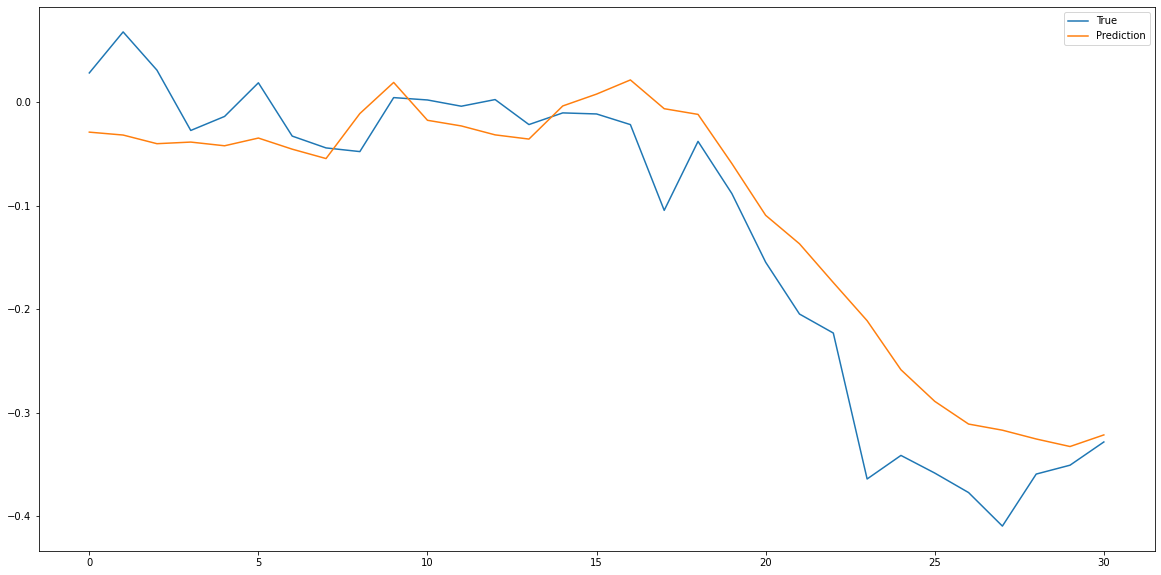

In [15]:
# prediction

pred = model.predict(x_test) # 훈련된 모델을 사용하여 이미지에 대한 예측을 만듦
print(pred.shape)

fig = plt.figure(facecolor='white', figsize=(20, 10))
ax = fig.add_subplot(111)
ax.plot(y_test, label='True')
ax.plot(pred, label='Prediction')
ax.legend()
plt.show()